# DensNet DL modeling on COVID-QU-Ex
In this notebook, we'll study an existing model for image recognition such as DenseNet201 and apply it on our dataset from Kaggle (https://www.kaggle.com/datasets/anasmohammedtahir/covidqu)


- Data will first be analyzed and prepare for modeling: A function is defined to load Kaggle data into working directory. We'll display raxw images and CLAHE treated images.

- The DenseNet201 model from Keras will be imported, used and fine-tuned before being trained on train set and validated on val set.

- The model will be evaluated on the test set.

- An Grad-Cam analysis will be perform to understand model classification parameters.

In [ ]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [1]:
# Cell to import necessary library
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

import os
%matplotlib inline

In [ ]:
# Cell to clean directory from previous test files or useless files:

#import shutil
#shutil.rmtree('/kaggle/working/COVID-EX-Qu-dataset/train')
#os.remove('/kaggle/working/COVID-EX-Qu-dataset/Models/DNet_baretv3_weights.weights.h5')

## 1- Data analysis
When first running this notebook, we'll need to transfer images files to the Kaggle working directory.

In [2]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base pat
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [ ]:
# Only run this cell if working files are not in kaggle working directory
import shutil
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

In [3]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


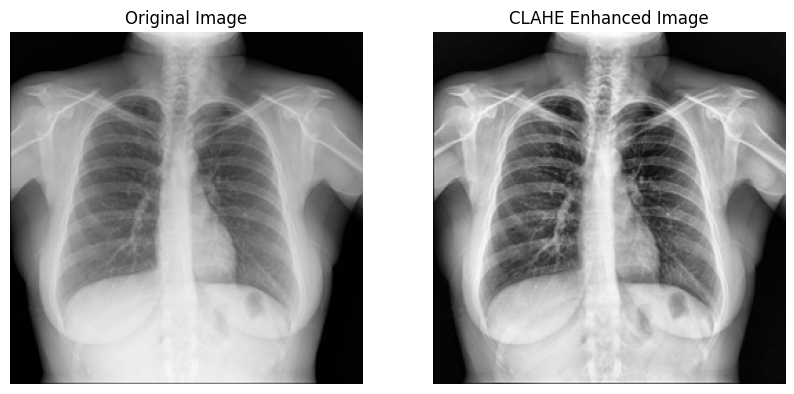

In [4]:
# Visual test of the future preprocessing:
# Evaluation of the CLAHE performance

setts = random.choice(sets)
group = random.choice(groups)

directory_path = os.path.join(destination_path, sett, group, 'images')

files = os.listdir(directory_path)
random_file = random.choice(files)

image_path = os.path.join(directory_path, random_file)

image = cv2.imread(image_path)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Apply CLAHE
clahe_image = clahe.apply(gray_image)
# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Display the original image in the first subplot
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the CLAHE-enhanced image in the second subplot
axes[1].imshow(cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB))
axes[1].set_title('CLAHE Enhanced Image')
axes[1].axis('off')
plt.show()

# 2- Data preparation

In [5]:
# Implementation of the CLAHE preprocessing:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Check if image is RGB and convert to grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Ensure image is of type uint8 for CLAHE
    img = img.astype('uint8')
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Normalize the image to [0, 1]
    img = img.astype('float32') / 255.0
    
    return img

# Data generators with the custom preprocessing function
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image)
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image)

In [6]:
# Preparation of the data set using image generator
batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="sparse",
                                                           target_size=(224, 224),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="sparse",
                                                         target_size=(224, 224),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="sparse",
                                                          target_size=(224, 224),
                                                          batch_size=batch_size, shuffle=False)
# shuffle=False argument is very important for model evaluation

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


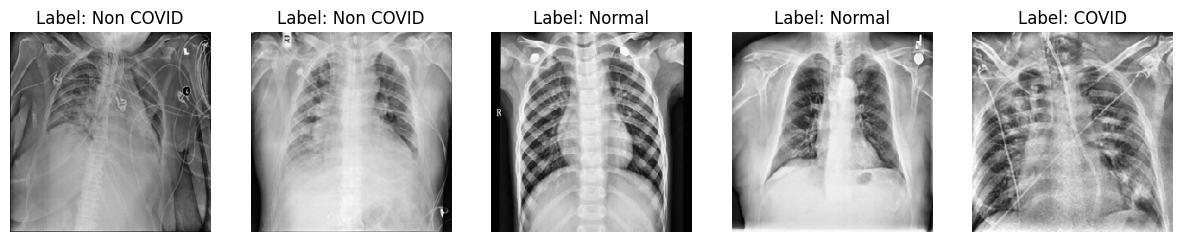

In [7]:
# Visual check of images in generators:

class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}
# Function to visualize images from a batch
def visualize_images(image_batch, label_batch, num_images=5):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image_batch[i])
        plt.title(f"Label: {class_names[label_batch[i]]}")
        plt.axis('off')
    plt.show()

# Retrieve a batch of images and labels from the generator
train_generator.reset()
batch_images, batch_labels = train_generator[1]

# Visualize the batch of images
visualize_images(batch_images, batch_labels)

# 3- DenseNet Model
The architecture of our model is based on a DenseNet201.

In [8]:
#Main architecture of the model
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[137:]:
        layer.trainable = True

    # Add custom classifier layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [9]:
# Model
Model_DNet = build_model()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
# Checking of model layers
Model_DNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,847,043 (71.90 MB)

 Trainable params: 17,320,451 (66.07 MB)

 Non-trainable params: 1,526,592 (5.82 MB)

In [ ]:
# Definition of callbacks:
from tensorflow.keras.callbacks import ReduceLROnPlateau


reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

In [ ]:
# MODEL TRAINING:
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_densenet_nonopt = Model_DNet.fit(train_generator, 
                                epochs = 30,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=test_generator,
                                validation_steps=nb_img_val//batch_size,
                                callbacks = [reduce_learning_rate]
                                )

In [ ]:
# Loss and accuracy analysis during training

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_densenet_nonopt.history['loss'])
plt.plot(history_densenet_nonopt.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_densenet_nonopt.history['accuracy'])
plt.plot(history_densenet_nonopt.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

## 5- RESULTS

In [ ]:
# Model saving
Model_DNet.save_weights('/kaggle/working/COVID-EX-Qu-dataset/Models/DNet_B_v0.weights.h5')

In [11]:
#If session re-loaded or any future use of the model: 
Model_DNet.load_weights('/kaggle/working/COVID-EX-Qu-dataset/Models/DNet_B_v0.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 990 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Model evaluation on test generator data
evaluation = Model_DNet.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

In [ ]:
# Confusion_ matrix:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions on the test data
predictions = Model_DNet.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(classification_report(true_classes, predicted_classes))
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized DenseNet')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


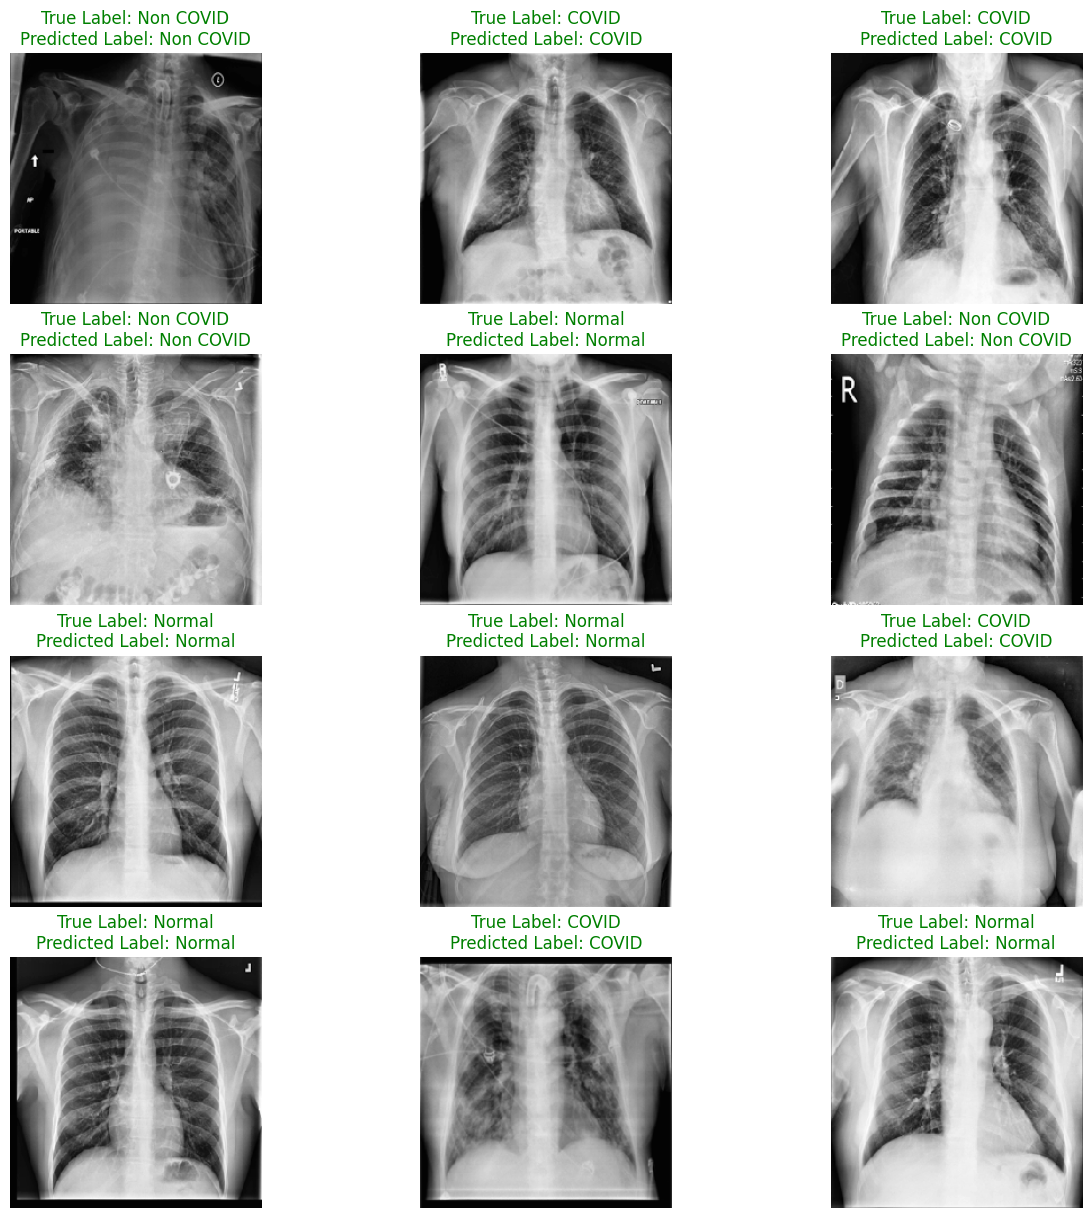

In [12]:
# Visualization of results on images from test_generator data:
class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}

# Function to apply the model on a batch of images and visualize the results
def apply_model_and_visualize_multiple_images(model, data_generator, num_images=12):
    plt.figure(figsize=(15, 15))
    data_generator.reset()
    
    for i in range(num_images):
        # Retrieve one image and its label from the generatorl 
        batch_images, batch_labels = random.choice(data_generator)
        image = batch_images[0]  # Take the first image from the batch
        label = round(batch_labels[0])  # Corresponding label
        
        # Reshape the image to (1, height, width, channels) for model prediction
        image = np.expand_dims(image, axis=0)
        
        # Apply the trained model to obtain prediction
        prediction = model.predict(image)
        
        # Round the predicted label to the nearest integer
        predicted_label = np.argmax(prediction)
        
        # Convert integer labels to class names
        true_class_name = class_names[label]
        predicted_class_name = class_names[predicted_label]
        
        # Visualize the result
        plt.subplot(4, 3, i+1)
        plt.imshow(image[0])
        
        # Determine title color based on whether true and predicted labels match
        title_color = 'green' if true_class_name == predicted_class_name else 'red'
        
        plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}", color=title_color)
        plt.axis('off')
    plt.show()

# Example usage for applying the model on multiple images from the validation set
apply_model_and_visualize_multiple_images(Model_DNet, test_generator, num_images=12)

# 6- GRAD-Cam analyses
As we need to understand how the model is classifiyng images, a grad-cam analyzes is performed.

In [13]:
model = Model_DNet
layer_name = 'conv5_block32_concat'
grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])

def compute_gradcam(image, class_index, model, layer_name):
    with tf.GradientTape() as tape:
        conv_output, predictions = model(image)
        loss = predictions[:, class_index]

    # Get the gradients of the predicted class with respect to the output feature map of the selected layer
    grads = tape.gradient(loss, conv_output)[0]

    # Pool the gradients across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the activations of the selected layer
    conv_output_value = conv_output[0]

    # Weight the activations by the gradients
    heatmap = tf.reduce_mean(conv_output_value * tf.expand_dims(tf.expand_dims(pooled_grads, axis=0), axis=0), axis=-1)

    # ReLU operation
    heatmap = tf.nn.relu(heatmap)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


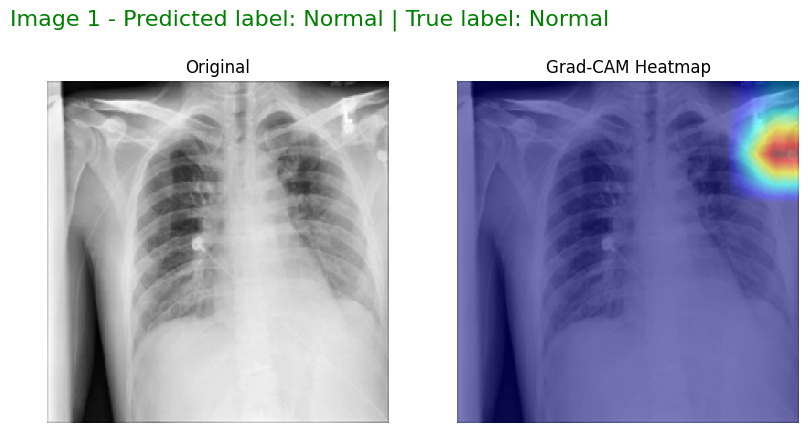

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


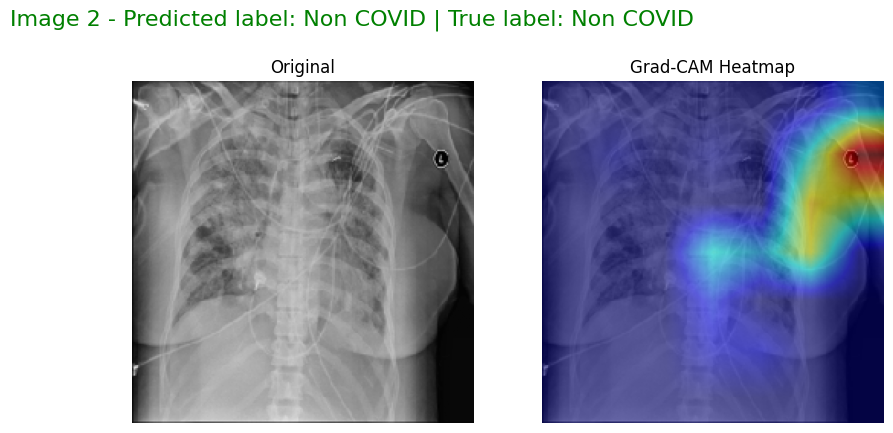

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


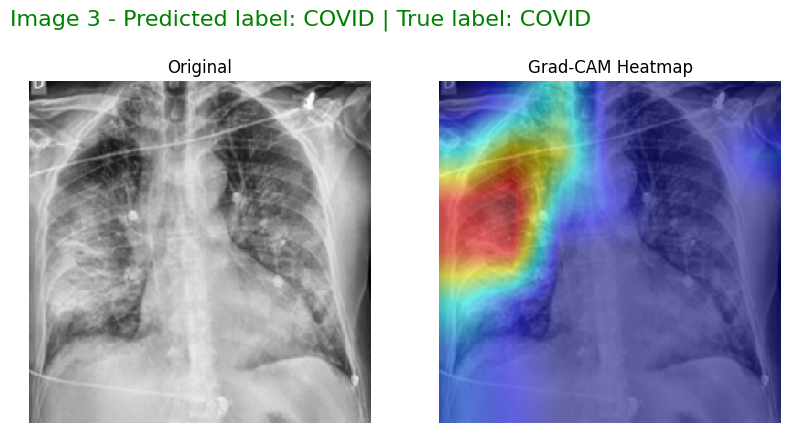

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


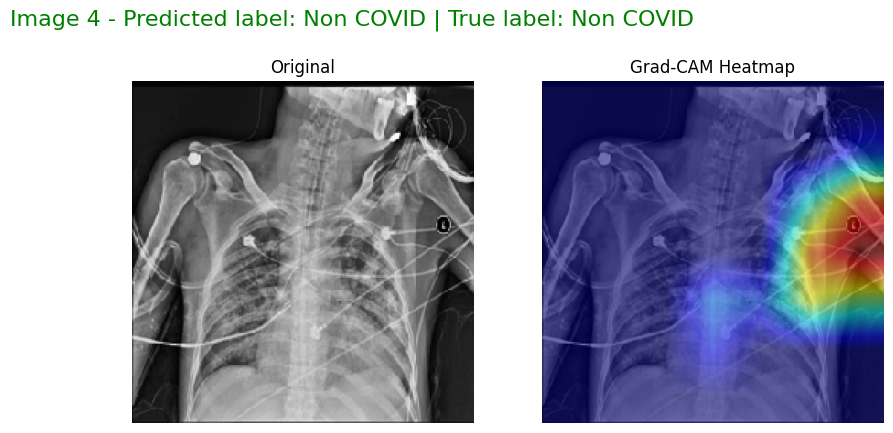

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


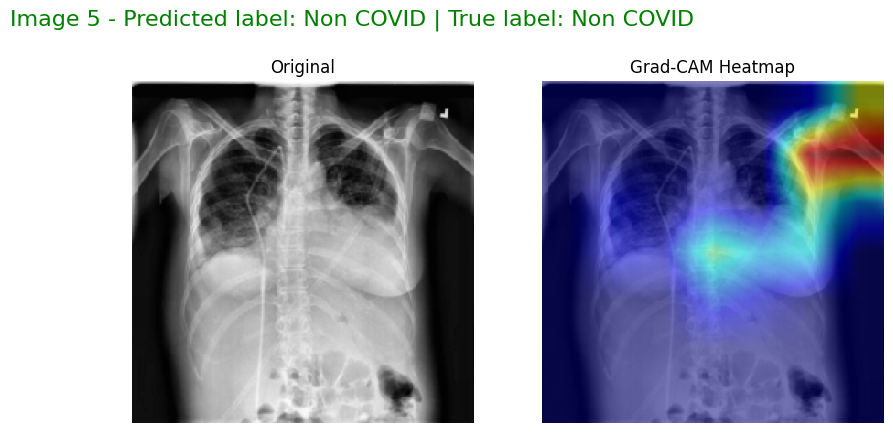

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


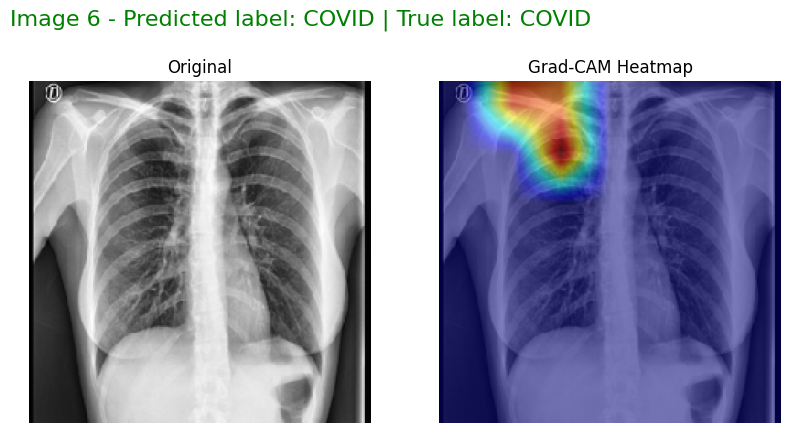

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


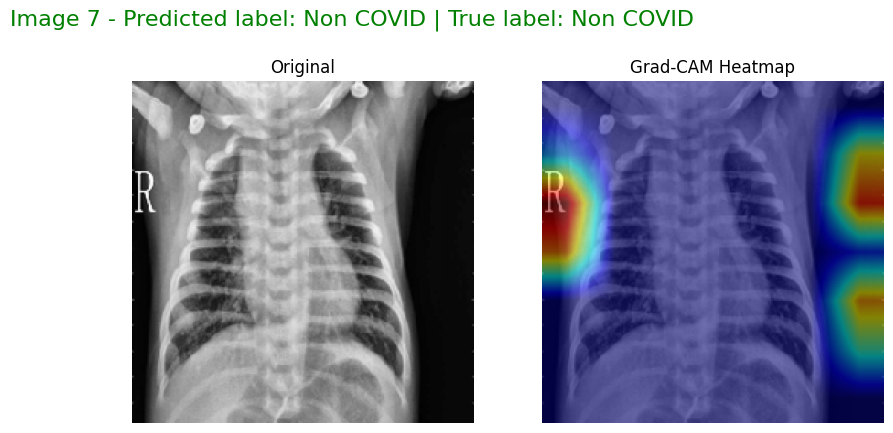

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


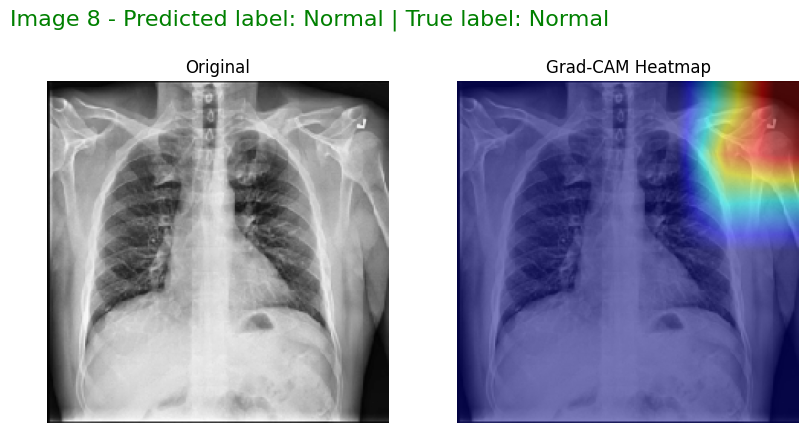

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


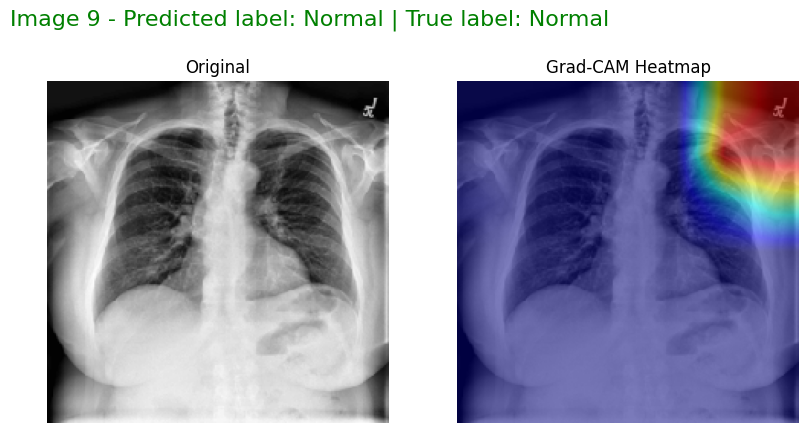

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


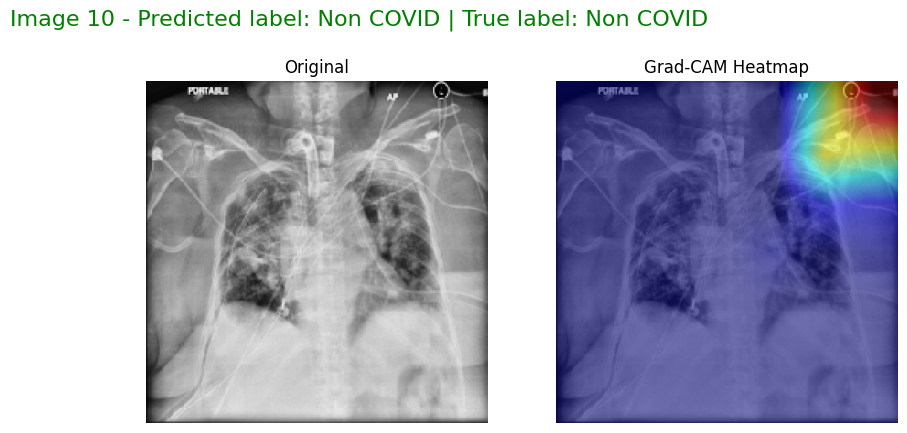

In [14]:
num_images_to_process = 10

# Iterate through the images
for i in range(num_images_to_process):
    batch_images, batch_labels = random.choice(test_generator)
    batch_image = batch_images[:num_images_to_process]  # Take the first image from the batch
    batch_label = batch_labels[:num_images_to_process]  # Corresponding label
    img_array = batch_image[i]
    image = np.expand_dims(img_array, axis=0)

    # Make predictions
    preds = model.predict(image)
    predicted_class = np.argmax(preds[0])
    heatmap = compute_gradcam(image, predicted_class, grad_model, layer_name)

    # Resize the heatmap to the original image size
    heatmap = tf.expand_dims(heatmap, axis=-1)  # Add an extra channel dimension
    heatmap = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]))

    # Convert the heatmap to numpy array
    heatmap = heatmap.numpy()

    # Normalize the heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap (jet or any other)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert heatmap to float32 and scale to [0, 1]
    heatmap = heatmap.astype(np.float32) / 255

    # Combine the heatmap with the original image
    superimposed_img = cv2.addWeighted(img_array.astype(np.float32), 0.5, heatmap, 0.5, 0)

    # Get the class label for the predicted class
    class_label = class_names[predicted_class] 
    real_label = round(batch_label[i])
    true_class_name = class_names[real_label]
    
    title_color = 'green' if true_class_name == class_label else 'red'

    # Plot the original image, the Grad-CAM heatmap, and the heatmap
    plt.figure(figsize=(15, 5))
    plt.suptitle('Image {} - Predicted label: {} | True label: {}'.format(i+1, class_label, true_class_name), fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with Matplotlib
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

# REFERENCES
[1] A. M. Tahir, M. E. H. Chowdhury, A. Khandakar, Y. Qiblawey, U. Khurshid, S. Kiranyaz, N. Ibtehaz, M. S. Rahman, S. Al-Madeed, S. Mahmud, M. Ezeddin, K. Hameed, and T. Hamid, “COVID-19 Infection Localization and Severity Grading from Chest X-ray Images”, Computers in Biology and Medicine, vol. 139, p. 105002, 2021, https://doi.org/10.1016/j.compbiomed.2021.105002.     \
[2] Anas M. Tahir, Muhammad E. H. Chowdhury, Yazan Qiblawey, Amith Khandakar, Tawsifur Rahman, Serkan Kiranyaz, Uzair Khurshid, Nabil Ibtehaz, Sakib Mahmud, and Maymouna Ezeddin, “COVID-QU-Ex .” Kaggle, 2021, https://doi.org/10.34740/kaggle/dsv/3122958. \
[3] T. Rahman, A. Khandakar, Y. Qiblawey A. Tahir S. Kiranyaz, S. Abul Kashem, M. Islam, S. Al Maadeed, S. Zughaier, M. Khan, M. Chowdhury, "Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-rays Images," Computers in Biology and Medicine, p. 104319, 2021, https://doi.org/10.1016/j.compbiomed.2021.104319. \
[4] A. Degerli, M. Ahishali, M. Yamac, S. Kiranyaz, M. E. H. Chowdhury, K. Hameed, T. Hamid, R. Mazhar, and M. Gabbouj, "Covid-19 infection map generation and detection from chest X-ray images," Health Inf Sci Syst 9, 15 (2021), https://doi.org/10.1007/s13755-021-00146-8. \
[5] M. E. H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M. A. Kadir, Z. B. Mahbub, K. R. Islam, M. S. Khan, A. Iqbal, N. A. Emadi, M. B. I. Reaz, M. T. Islam, "Can AI Help in Screening Viral and COVID-19 Pneumonia?," IEEE Access, vol. 8, pp. 132665-132676, 2020, https://doi.org/10.1109/ACCESS.2020.3010287.